#### [  [HOME](http://ifni.co) | [Bi](http://ifni.co/bi/TOC.html) ]

In [2]:
%matplotlib inline

import sys
sys.path.append('../lib')

# Integration

This chapter would explore the ways to integrate Bi with Neuro networks and other systems.

There are probably numerous was to integrate systems like Neuro Networks, Numenta Grok, general Programming languages. Currently we will look into only one of them.

The easiest way to use any system with Bi is via ATOMS. What do I mean ?
Let's take for example neuro network that does classification. The end result of classification is a LABEL, which in Bi lingo corresponds to a SYMBOL/ATOM. So we can just use this label directly in Bi.

### Summing numbers with MNIST

Lets take the simple example of summing numbers.
We will use MNIST image database of handwritten digits as input and as a result we expect the sum of the numbers respresented by those two images.

Here is the work-flow :

  - Train NN on the MNIST database to recognize the numbers represented by the images.
  - Pick randomly two images of a two numbers
  - Pass them trough the NN and get back the recognized numbers as ATOMS
  - Sum the numbers (via Bi program)
  
Good so far ... except v0.1 does not support arithmetic, but don't fret we will think of something and at the same time learn some Prolog/Bi. What's not to like ;) 

The Bi/Prolog program will look like this :

```prolog
next(0,1).
next(1,2).
next(2,3).
next(3,4).
next(4,5).
next(5,6).
next(6,7).
next(7,8).
next(8,9).
next(9,10).
next(10,11).
next(11,12).
next(12,13).
next(13,14).
next(14,15).
next(15,16).
next(16,17).
next(17,18).
next(18,19).
next(19,20).

prev(A,B) :- next(B,A).
sum(S,0,S).
sum(A,B,S) :- next(A,A1), prev(B,B1), sum(A1,B1,S).
```

Because we can't do arithmetic we start with definition of successors for the numbers between 0 .. 20. That will be the maximum sum we can have. BTW this app is simply illustration of how to integrate the two systems, not an attempt to implement arithmetic.

I provided a class that implements the whole integration, once we are done with this tutorial look at the code.

In [3]:
import os
os.chdir('../test')
from integrate import *

Using Theano backend.


On initialization the class will load the MNIST database so that we can pick images for input for the NN.

Also it will load the pre-compiled Convolution NN model. (You can also run the training separately by running mnist_cnn.py, but it takes close to one hour, that is why I precompiled it for you. BTW it uses Keras NN framework, which can work on top of Theano or TensorFlow).

And third by default we will use [CUPInteger](More_CUPS.ipynb) module to handle the number-atoms. You can switch it off if you want by passing a flag : **cupi=False**.

In [4]:
it = Integrate()

Using <ints> .....
loading MNIST model and weights ...
loading MNIST ...


Now lets get back to the code. To simulate summation, we need first to learn to count.
This as you saw is done by adding the successor numbers as facts in the KDB. Lets try and see if it works :

In [5]:
it.eng.query('next', ['5', 'Next'])

{'Next': '6'}

Again don't forget we use string that starts with Upper_case for variables.

Next step is to learn to count backwards. We will do that by creating a rule that reuses the successor-facts we already added, namely :  

`prev(A,B) :- next(B,A).`

This as we discussed relies on **Unification**.

Lets test it :

In [6]:
it.eng.query('prev', ['5', 'Prev'])

{'Prev': '4'}

BTW because of the way unification work we could used **next** to do the same thing, but **prev** is more semantically clear. Do you see Unification works both ways, not like assignment.

In [7]:
it.eng.query('next', ['Prev', '5'])

{'Prev': '4'}

Finally **sum** is a recursive clause, build in two parts.

```
sum(S,0,S).
sum(A,B,S) :- next(A,A1), prev(B,B1), sum(A1,B1,S).
```

First one is the condition that limits the recursion, it has to be physically before the main body, because of the way SDL resolution works ... the search direction in the KDB is TOP => DOWN and within the rule-clause is LEFT => RIGHT.

The first two terms in **`sum(X,Y,Z)`** are the two inputs, the third one is there to collect the result.
The hint is coming from unification. Once the second term hit ZERO the first term unifies with the third.
Lets say the sum is 7, then the final call will look like **`sum(7,0,S)`** which have to unify with **`sum(S,0,S)`**.

In [11]:
it.eng.unify(('sum', '7', '0','S' ), ('sum', 'S', '0','S'), {})

{'S': '7'}

Let's look at the second rule. What it does in essence is to find the successor of the first number and the predecessor of the second number. In English this means that we will increase the first number until the second reaches ZERO.

The last clause is the recursive call to the same rule-clause this time with the new numbers, until we hit the limiting condition i.e. the second number becomes ZERO. 

Lets try it :

In [8]:
it.eng.query('sum', ['1', '3', 'Result'])

{'Result': '4'}

### Misc stuff

Now that we know how the summation works, lets explore the other parts we need for our small project.

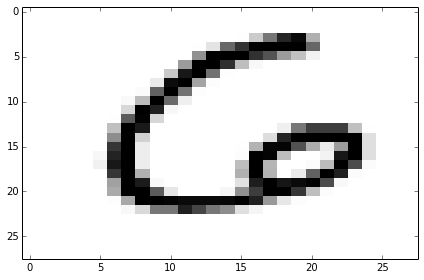

In [28]:
it.imshow(it.digit2img(6)[0])

The **.digit2img()** call picks randomly an image for the specified digit from the MNIST database. There are many different images of every digit. We will simulate handwriting by selecting different images.

Because **.digit2img()** returns numpy array, we can use **.imshow()** to display the image as I've shown up above.

The final thing we need for our task is based on an image to decipher which digit it is. That is the work for the trained NN model.

In [31]:
it.predict(it.digit2img(6)[0])

6

Lets view the routine of the whole process :

```python

	#given two digits, do the whole process :
	#   - convert digit --> image
	#   - recognize the image as digit
	#   - sum the digits using Bi
	#        digits are recognized as atoms
	def calc(self, v1, v2) :
		log.info("calc> v1:%s, v2:%s" % (v1, v2))
		log.info("first pick image that represent the values (randomly)")
		img1, _ = self.digit2img(v1)
		img2, _ = self.digit2img(v2)
		log.info('second: pass trough ConvNN')
		d1 = self.predict(img1)
		d2 = self.predict(img2)
		log.info("predicted> d1:%s, d2:%s" % (d1, d2))
		log.info('... now sum them using Bi lang')
		mgu = self.sum(d1,d2)
		log.info("\n\tresult> %s + %s = %s" % (d1,d2,mgu['Sum']))

```

Lets try it :

In [30]:
it.calc(3,4)

calc> v1:3, v2:4
first pick image that represent the values (randomly)
second: pass trough ConvNN
predicted> d1:3, d2:4
... now sum them using Bi lang

	result> 3 + 4 = 7


That is all folks !!!